In [216]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [217]:
""" INPUTS """
FINE_TUNING = 1

VAL_SPLIT = 0.2
BATCH_SIZE = 4
N_EPOCHS = 300

# Learning rate
LR = 0.07
LR_SCHEDULER = 1
LR_SCHEDULER_STEP_SIZE = 20
LR_SCHEDULER_GAMMA = 0.7

# Regularizations
DROPOUT_LAYERS = []
DROPOUT_RATE = 0.5
BATCH_NORMALIZATION = 1
L2_REG = 0
L2_REG_LAMBDA = 1e-4

# Fine-tuning parameters:
LAYERS_NEURONS = 64, 32, 16, 8

# CustomCNN parameters (FINE_TUNING = 0):
CONV_NEURONS = 32, 64, 128, 256
FC_NEURONS = 128, 64, 32, 8
INPUT_SHAPE = (3, 20, 60)

# Other
RESIZE_FACTOR = 5

Dataset settings

In [218]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        
        # Collect all images and their labels
        # labels: [wake = 1 , east = 1]
        for folder in ['idle-east', 'idle-west', 'wake-east', 'wake-west']:
            label = [int(folder.split("-")[0] == 'wake'), int(folder.split("-")[1] == 'east')]
            folder_path = os.path.join(root_dir, folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                self.data.append((img_path, label))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((INPUT_SHAPE[1] * RESIZE_FACTOR, INPUT_SHAPE[2] * RESIZE_FACTOR), max_size=None, antialias=True),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.Normalize(mean=(0.425,0.415,0.405), std=(0.205,0.205,0.205)),   # from a kaggle's notebook
])

In [219]:
# Create the dataset and dataloader
root_dir = r"D:\wake_direction_dataset"
dataset = CustomDataset(root_dir, transform=transform)

dataset_size = len(dataset)
validation_split = VAL_SPLIT
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

train_dataset, val_dataset = random_split(dataset, [train_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"{len(train_dataset)} samples in training data")
print(f"{len(val_dataset)} samples in validation data")

116 samples in training data
29 samples in validation data


Model declaration

In [220]:
class CustomCNN(nn.Module):
    def __init__(self, conv_layers, fc_layers, input_shape):
        super(CustomCNN, self).__init__()
        
        self.conv_layers = nn.ModuleList()
        in_channels = input_shape[0]

        # Create convolutional layers
        for out_channels in conv_layers:
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            in_channels = out_channels
        
        # Calculate the flattened size after all convolution and pooling layers
        self.feature_size = self._get_feature_size(input_shape, len(conv_layers))

        # Create fully connected layers
        self.fc_layers = nn.ModuleList()
        input_size = self.feature_size

        for output_size in fc_layers:
            self.fc_layers.append(nn.Linear(input_size, output_size))
            input_size = output_size
        
        # Add the final output layer (assuming binary classification with 2 output nodes)
        self.output_layer = nn.Linear(input_size, 2)

    def _get_feature_size(self, input_shape, num_conv_layers):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            for _ in range(num_conv_layers):
                x = F.max_pool2d(F.relu(self.conv_layers[_](x)), 2)
            return x.numel()

    def forward(self, x):
        for conv in self.conv_layers:
            x = F.relu(conv(x))
            x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)
        
        for fc in self.fc_layers:
            x = F.relu(fc(x))
        
        x = self.output_layer(x)
        return torch.sigmoid(x)

    
class CustomFC(nn.Module):
    def __init__(self, num_features, layers):
        super(CustomFC, self).__init__()
        self.fc = self.create_fc_layers(num_features, layers)
    
    def create_fc_layers(self, num_features, layers):
        layer_list = []
        input_size = num_features

        for i, output_size in enumerate(layers):
            layer_list.append(nn.Linear(input_size, output_size))
            if BATCH_NORMALIZATION:
                layer_list.append(nn.BatchNorm1d(output_size))
            layer_list.append(nn.ReLU())
            if i in DROPOUT_LAYERS:
                layer_list.append(nn.Dropout(DROPOUT_RATE))
            input_size = output_size

        # Add the final output layer
        layer_list.append(nn.Linear(input_size, 2))  # Assuming binary classification with 2 output nodes
        layer_list.append(nn.Sigmoid())

        return nn.Sequential(*layer_list)

    def forward(self, x):
        x = self.fc(x)
        return x

In [221]:
from torchvision.models import Inception_V3_Weights

if FINE_TUNING:
    """ Transfer learning approach """
    # Load pre-trained ResNet model
    model = models.resnet18(pretrained=True)
    # model = models.resnet50(pretrained=True)
    # model = models.inception_v3(pretrained=True)
    # model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)

    # Freeze all the layers
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final fully connected layer
    num_features = model.fc.in_features
    print(num_features)

    model.fc = CustomFC(num_features, LAYERS_NEURONS)
else:
    """ Pre-training approach """
    model = CustomCNN(CONV_NEURONS, FC_NEURONS, INPUT_SHAPE) # Ensure input shape aligns with your data

512


In [222]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Optimizer and metrics

In [223]:
criterion = nn.BCELoss()

if FINE_TUNING:
    if L2_REG:
        optimizer = optim.Adam(model.fc.parameters(), lr=LR, weight_decay=L2_REG_LAMBDA)
    else:
        optimizer = optim.Adam(model.fc.parameters(), lr=LR)
else:
    if L2_REG:
        optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=L2_REG_LAMBDA)
    else:
        optimizer = optim.Adam(model.parameters(), lr=LR)

if LR_SCHEDULER:
    scheduler = StepLR(optimizer, step_size=LR_SCHEDULER_STEP_SIZE, gamma=LR_SCHEDULER_GAMMA)

Training procedure

In [229]:
model.to(device)

training_loss = []
training_acc = []
validation_loss = []
validation_acc = []

for epoch in range(N_EPOCHS):
    model.train()

    running_train_loss = 0.0
    running_train_corrects = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        # print(outputs)
        # print(labels)
        loss = criterion(outputs, labels)
        # _, preds = torch.max(outputs, 1)   # when we have one label which is one hot encoded
        preds = (outputs > 0.5).float()      # when we have one or multiple labels which are binary
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        # print(loss.item())
        running_train_corrects += torch.sum(preds == labels.data) / labels.numel()
    
    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_acc =  int(running_train_corrects * 100 / len(train_loader))
    training_loss.append(epoch_train_loss)
    training_acc.append(epoch_train_acc)

    if LR_SCHEDULER:
        scheduler.step()
    
    running_val_loss = 0.0
    running_val_corrects = 0

    # Validation phase
    model.eval()

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            # _, preds = torch.max(outputs, 1)   # when we have one label which is one hot encoded
            preds = (outputs > 0.5).float()      # when we have one or multiple labels which are binary
            running_val_loss += loss.item()
            running_val_corrects += torch.sum(preds == labels.data) / labels.numel()
    
    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_acc =  int(running_val_corrects * 100 / len(val_loader))
    validation_loss.append(epoch_val_loss)
    validation_acc.append(epoch_val_acc)
    
    print(f"Epoch [{epoch+1:03d}/{N_EPOCHS}]     train_Loss: {epoch_train_loss:.4f}   train_acc: {epoch_train_acc}%    val_Loss: {epoch_val_loss:.4f}   val_acc: {epoch_val_acc}%")
    # print(f"Epoch [{epoch+1}/{N_EPOCHS}]     train_Loss: {epoch_train_loss:.4f}   val_Loss: {epoch_val_loss:.4f}")
    # print(f"Epoch [{epoch+1}/{N_EPOCHS}]\nTrain Loss: {epoch_train_loss:.4f}   Val Loss: {epoch_val_loss:.4f}\n--------")

print("Finished Training")

Epoch [001/300]     train_Loss: 0.6487   train_acc: 61%    val_Loss: 0.5944   val_acc: 64%
Epoch [002/300]     train_Loss: 0.6498   train_acc: 61%    val_Loss: 0.5941   val_acc: 64%
Epoch [003/300]     train_Loss: 0.6489   train_acc: 61%    val_Loss: 0.5946   val_acc: 64%
Epoch [004/300]     train_Loss: 0.6497   train_acc: 61%    val_Loss: 0.5955   val_acc: 64%
Epoch [005/300]     train_Loss: 0.6494   train_acc: 61%    val_Loss: 0.5926   val_acc: 64%
Epoch [006/300]     train_Loss: 0.6491   train_acc: 61%    val_Loss: 0.5941   val_acc: 64%
Epoch [007/300]     train_Loss: 0.6501   train_acc: 61%    val_Loss: 0.5903   val_acc: 64%
Epoch [008/300]     train_Loss: 0.6493   train_acc: 61%    val_Loss: 0.5925   val_acc: 64%
Epoch [009/300]     train_Loss: 0.6498   train_acc: 61%    val_Loss: 0.5941   val_acc: 64%
Epoch [010/300]     train_Loss: 0.6499   train_acc: 61%    val_Loss: 0.5952   val_acc: 64%
Epoch [011/300]     train_Loss: 0.6493   train_acc: 61%    val_Loss: 0.5903   val_acc: 64%

KeyboardInterrupt: 

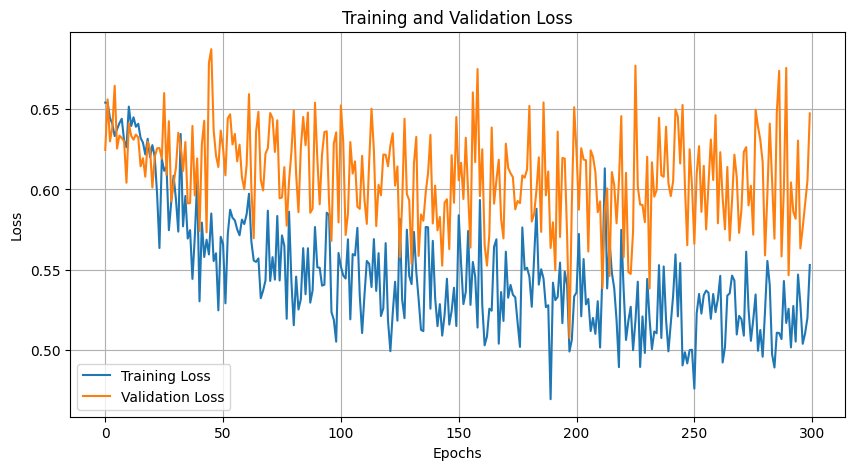

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(N_EPOCHS), training_loss, label='Training Loss')
plt.plot(range(N_EPOCHS), validation_loss, label='Validation Loss')
plt.xlabel('Epochs');plt.ylabel('Loss');plt.title('Training and Validation Loss');plt.legend();plt.grid(True)
plt.show()


Model evaluation

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / (total * 2)  # Since we have 2 labels per image
    print(f"Accuracy: {accuracy * 100:.2f}%")

# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# evaluate_model(model, test_loader)

evaluate_model(model, train_loader)
evaluate_model(model, val_loader)

Accuracy: 72.84%
Accuracy: 68.97%


Prediction: ['idle', 'east']


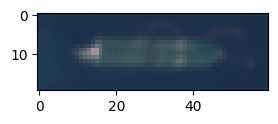

In [ ]:
from PIL import Image

# image_path = r"D:\wake_direction_dataset\wake-west\10476_193.png"
image_path = r"D:\wake_direction_dataset\idle-east\10479_[550.2622680664062,914.1808471679688,592.4557495117188,930.5807495117188]_324.png"
# image_path = r"D:\wake_direction_dataset\wake-east\10489_[710.275390625,305.6343688964844,730.1436767578125,321.1022033691406]_146.png"
# image_path = r"D:\wake_direction_dataset\wake-east\10772_[537.879638671875,1212.656494140625,557.05419921875,1218.6268310546875]_133.png"
# image_path = r"D:\wake_direction_dataset\wake-east\10172_[1981.55029296875,1024.7581787109375,2001.47021484375,1038.564697265625]_175.png"
# image_path = r"D:\wake_direction_dataset\wake-east\10760_130.png"

image = Image.open(image_path)
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension and apply transforms
input_tensor = input_tensor.to(device)

model.eval()
with torch.no_grad():
    output = model(input_tensor)

pred = ["wake" if output[0][0] >= 0.5 else "idle", "east" if output[0][1] >= 0.5 else "west"]

print(f'Prediction: {pred}')

plt.figure(figsize=(3, 1))
plt.imshow(image); plt.show() 

Save the model state

In [ ]:
# model_path = r'D:\NLP 1\Satellite_monitoring-web\fetch_data\utilities\wake-align_model\models\model.pth'
# torch.save(model.state_dict(), model_path)

# model.load_state_dict(torch.load(model_path))
# model.eval()